In [331]:
%reset -f

import numpy as np
import matplotlib.pyplot as plt

# Plots LaTeX-Style
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

In [332]:
# Define System
T = 1
h = 0.1
n = int(T/h) + 1

A = np.array([[0, 1], [-1, 0]])
Ak = np.array([[1, h],[-h, 1]])
Ck = np.array([[1, 0],[0, 1]]) # z = x, y
x0 = np.array([1, 1])

x_var = 0.1
z_var = 0.1
Q = np.array([[x_var, 0], [0, x_var]])
R =np.array([[z_var, 0], [0, z_var]])

# Real dynamics
x_real = np.zeros((n, 2))
x_real[0] = x0
for i in range(1, n):
    x_real[i] = x_real[i-1] + h * np.dot(A, x_real[i-1])


z = np.zeros((n, 2))
z[0] = np.dot(Ck, x0) + np.random.normal(0, z_var, size=(1,2))

In [333]:
# Kalman
x_pred = np.zeros((n, 2))
Cov_pred = np.zeros((n, 2, 2))

x_pred[0] = x0
Cov_pred[0] = Q

x_filt = np.zeros((n, 2))
Cov_filt = np.zeros((n, 2, 2))

x_filt[0] = x0
Cov_filt[0] = Q

# Nearby filters
x_fnear_f = np.zeros((10, n, 2))
fnear_amp = [0.9, 0.92, 0.96, 0.98, 0.99, 1.02, 1.06, 1.1, 1.15, 1.2]

# Avg error
e_filters = np.zeros(11)
std_filters = np.zeros(11)
#error_filters = np.zeros((11,1))
error_filters = {}
for i in range(11):
    error_filters[i] = []

In [334]:
for s in range(100):
    for t in range(n):
        x_pred[t] = np.dot(Ak, x_pred[t-1])
        Cov_pred[t] = np.dot(np.dot(Ak, Cov_pred[t-1]), Ak.T) + Q

        z[t] = np.dot(Ck, x_real[t]) + np.random.normal(0, z_var, size=(1,2))
        #Kalman
        K = np.dot(np.dot(Cov_pred[t], Ck.T), np.linalg.inv(np.dot(np.dot(Ck, Cov_pred[t]), Ck.T) + R))
        x_filt[t] = x_pred[t] + np.dot(K, (z[t] - np.dot(Ck, x_pred[t])))
        # Cov_filt[t] = Cov_pred[t] - K * Ck @ Cov_pred[t]
        e_filters[5] += np.linalg.norm(x_filt[t] - x_real[t])/(n*100)
        error_filters[5] = np.append(error_filters[5], np.linalg.norm(x_filt[t] - x_real[t]))

        #Filters 1-10
        for f in range(0, 5):
            Kf = K*fnear_amp[f]
            x_fnear_f[f-1, t] = x_pred[t] + np.dot(Kf, (z[t] - np.dot(Ck, x_pred[t])))
            e_filters[f] += np.linalg.norm(x_fnear_f[f-1, t] - x_real[t])/(n*100)
            error_filters[f] = np.append(error_filters[f], np.linalg.norm(x_fnear_f[f-1, t] - x_real[t]))
        for f in range(6, 11):
            Kf = K*fnear_amp[f-1]
            x_fnear_f[f-1, t] = x_pred[t] + np.dot(Kf, (z[t] - np.dot(Ck, x_pred[t])))
            e_filters[f] += np.linalg.norm(x_fnear_f[f-1, t] - x_real[t])/(n*100)
            error_filters[f] = np.append(error_filters[f], np.linalg.norm(x_fnear_f[f-1, t] - x_real[t]))

for i in range(11):
    std_filters[i] = np.std(error_filters[i])
#print(std_filters)

[0.0835509  0.08028853 0.07198441 0.06923079 0.06870367 0.06895501
 0.07142844 0.08286523 0.0963533  0.10984606 0.12009293]


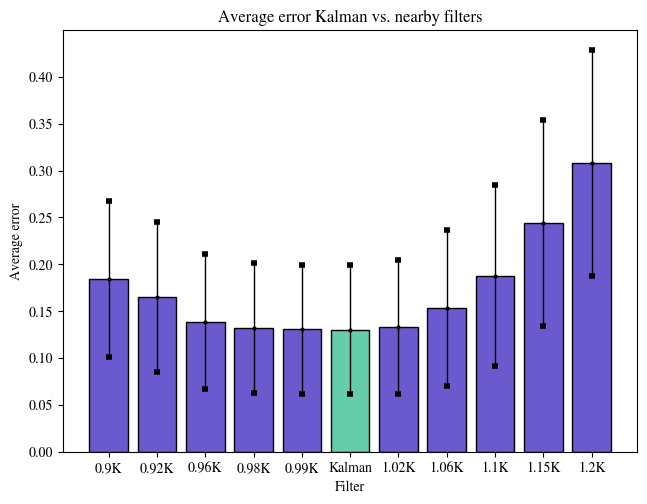

In [335]:
fig, ax = plt.subplots()
fig.tight_layout()

x_axis = [str(fnear_amp[0]) + 'K', str(fnear_amp[1]) + 'K', str(fnear_amp[2]) + 'K', str(fnear_amp[3]) + 'K', str(fnear_amp[4]) + 'K', 'Kalman', str(fnear_amp[5]) + 'K', str(fnear_amp[6]) + 'K', str(fnear_amp[7]) + 'K', str(fnear_amp[8]) + 'K', str(fnear_amp[9]) + 'K']
barlist = ax.bar(x_axis, e_filters, color='slateblue', edgecolor='k')
barlist[5].set_color('mediumaquamarine')
barlist[5].set_edgecolor('k')
ax.errorbar(x_axis, e_filters, std_filters, fmt='.', color='Black', elinewidth=1,capthick=4,errorevery=1, alpha=1, ms=4, capsize = 2)
#ax.set_ylim(bottom=np.amin(e_filters)-0.01, top=np.amax(e_filters)+0.01)

ax.set_xlabel('Filter')
ax.set_ylabel('Average error')
ax.set_title('Average error Kalman vs. nearby filters')
plt.savefig('HW3_3_error.png', dpi=300)
plt.show()